# Packages

In [1]:
# Visualisation
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from pyvis.network import Network
import shap


# Data analysis / Data processing
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format
from datetime import time, timedelta, datetime
import numpy as np
import networkx as nx
from collections import defaultdict
import ast
from ydata_profiling import ProfileReport
import re
from typing import Set, List, Dict
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Maths & Stats
import math 
import scipy.stats as st
from scipy import stats
from scipy.stats import norm
import statsmodels.stats.weightstats as ws
from statsmodels.stats.proportion import test_proportions_2indep
import AB_library
import random

# System library
import os
import ipywidgets
import warnings
import pandas_gbq
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
tqdm.pandas()
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format='retina'
# from itables import init_notebook_mode
# init_notebook_mode(all_interactive=True)
import openpyxl

# Data connection
from google.cloud import bigquery
bigquery_client = bigquery.Client(project='analytics-dev-333113')


# Useful functions
def cycle_sql(start, end, query, weeks=False):
    """
    You have to use {date} in your script to add cycle date into this backets
    """
    date_start = datetime.strptime(start, '%Y-%m-%d')
    date_end = datetime.strptime(end, '%Y-%m-%d')

    if weeks == False:
        daterange = [(date_start + timedelta(days=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days)+1)]
    else:
        daterange = [(date_start + timedelta(weeks=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days//7)+1)] # weeks dividing days by 7

    total_df = pd.DataFrame()

    counter = 0

    for date in daterange:
        counter+=1
        print(f"{counter}) Uploading - {date}:", datetime.today().strftime('%Y-%m-%d %H:%M:%S'))
        script = query.format(date = date)
        df_cycle = bigquery_client.query(script).to_dataframe()
        if df_cycle.empty == True:
            print('Dataframe is empty')
        total_df = pd.concat([df_cycle, total_df])
    return total_df

def read_bq(query, project='analytics-dev-333113'):
    client = bigquery.Client(project=project)
    query_job = client.query(query)
    result_df = query_job.to_dataframe()
    return result_df

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(
        html_str.replace('table','table style="display:inline"'), 
        raw=True
    )

def writing_excel(name:str, dataset1=None, dataset2=None, dataset3=None, dataset4=None):
    with pd.ExcelWriter(f"{name}.xlsx") as writer:

    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet

        if dataset1 is not None:
            if dataset2 is not None:
                if dataset3 is not None:
                    if dataset4 is not None:
                        dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                        #   index=False
                                            )
                        dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                        #   index=False
                                            )
                        dataset3.to_excel(writer, sheet_name=f"3-{name}", 
                                        #   index=False
                                            )
                        dataset4.to_excel(writer, sheet_name=f"4-{name}", 
                                        #   index=False
                                            )
                    else:
                        dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                        #   index=False
                                            )
                        dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                        #   index=False
                                            )
                        dataset3.to_excel(writer, sheet_name=f"3-{name}", 
                                        #   index=False
                                            )
                else:
                    dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                    #   index=False
                                        )
                    dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                    #   index=False
                                        )
            else:
                dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                #   index=False
                                    )

        print('DataFrame is written to Excel File successfully.') 

# Research

### Preparing the data

In [ ]:
# df_sample = pd.read_csv('analytics_dev_333113ty_score_total_for_ml.csv')

df_sample = pd.read_csv('/Users/renatyunison/Desktop/VSC scripts/Working/new_data_scoring.csv')

df_sample.head()

In [ ]:
def get_device_category(model: str) -> str:

    device_price_map = {
    'pro max': 'premium', 'ultra': 'premium', 'galaxy z': 'premium',
    'galaxy s': 'premium', 'fold': 'premium', 'flip': 'premium',
    'pixel': 'premium', 'pro': 'premium', 'iphone': 'premium',
    'rog': 'premium', 'sony': 'premium', 
    
    'oneplus': 'mid-range', 'honor': 'mid-range', 'huawei': 'mid-range',
    'galaxy a': 'mid-range', 'samsung': 'mid-range', 'pixel a': 'mid-range',
    'nord': 'mid-range', 'realme': 'mid-range', 'oppo': 'mid-range',
    'xiaomi': 'mid-range', 'motorola': 'mid-range', 'vivo': 'mid-range',
    'iqoo': 'mid-range', 'lge': 'mid-range', 'nothing': 'mid-range',
    'tcl': 'mid-range', 'nubia': 'mid-range', 'asus': 'mid-range',
    
    'sm-a': 'budget', 'moto g': 'budget', 'lite': 'budget',
    'redmi': 'budget', 'poco': 'budget', 'infinix': 'budget',
    'tecno': 'budget', 'lenovo': 'budget', 'nokia': 'budget',
    'itel': 'budget', 'lava': 'budget', 'zte': 'budget', 'op': 'budget',
    'ulefone': 'budget', 'sparx': 'budget', 'hisense': 'budget',
    'blackview': 'budget', 'cubot': 'budget', 'doogee': 'budget',
    'benco': 'budget', 'vgo_tel': 'budget', 'hmd': 'budget',
    'villaon': 'budget', 
    'vios': 'budget', 
    'marcel': 'budget', 
    'cg_mobiles': 'budget', 
    'ulesson': 'budget', 
    'mobice': 'budget', 
    'mirage': 'budget' 
}

    if not isinstance(model, str):
        return 'unknown'

    cleaned_model = model.lower().strip()
    cleaned_model = re.sub(r'[^\w\s]', '', cleaned_model)
    cleaned_model = re.sub(r'\s+', ' ', cleaned_model).strip()

    for keyword, category in device_price_map.items():
        if keyword in cleaned_model:
            return category
    
    return 'unknown' 


df_sample['device_price_category'] = df_sample['devicemodel'].apply(get_device_category)

df_sample.head()

In [ ]:
def create_name_suspicious_flag(df: pd.DataFrame) -> pd.DataFrame:

    import unicodedata

    common_names_whitelist = {
        'michael', 'john', 'anna', 'mary', 'david', 'chris', 'james', 'anna',
        'robert', 'william', 'joseph', 'charles', 'thomas', 'daniel', 'matthew',
        'elizabeth', 'sandra', 'barbara', 'patricia', 'jennifer', 'maria',
        'hector', 'adriana', 'rodrigo', 'italo', 'karen', 'julia', 'fabio', 'antonio',
        'thaylla', 'rania', 'lwazi', 'miriam', 'ronaldo', 'costanza', 'fernando',
        'vanessa', 'nigel', 'rudy', 'dimitri', 'sharon', 'mavuzo', 'ana', 'danny',
        'paola', 'david', 'camila', 'alexis', 'alejandra', 'dante', 'juanita',
        'wilmer', 'william', 'fernanda', 'leon', 'jeremy', 'atif', 'judith',
        'thiago', 'michel', 'didier', 'isaias', 'melissa', 'nayara', 'kaitlin',
        'karla', 'anthony', 'gerson', 'daniel', 'alfred', 'ailton', 'victoria',
        'mirzhan', 'миржан' # Добавлены имена из вашего списка
    }

    suspicious_ngrams = {
        'vv', 'ww', 'qq', 'jj', 'kk', 'uu', 'oo', 'yy', 'zz',
        'qwe', 'asd', 'zxc', 'rty', 'fgh', 'vbn', 'tyu', 'ghj', 'bnm', 'dfg', 'jkl', 'uio', 'iop', 'klj',
        'j.d', 'j.r', 'j d', 'j r', 'k d', 'l d', 'l r', 'r d', 'jd', 'jr', 'kl', 'gh', 'kk', 'qq',
        '123', '234', '345', '456', '567', '678', '789', '890', '000',
        'abc', 'xyz', 'mnp', 'qaz', 'wsx', 'edc',
        'b1', 'c1', 'd1', 'e1', 'f1',
        '1a', '2a', '3a', '4a', '5a',
    }

    def has_repeated_chars(s: str) -> bool:
        """
        Проверяет, содержит ли строка повторяющийся символ 3 или более раз подряд.
        """
        return bool(re.search(r'(.)\1\1', s))
    
    def normalize_name(s: str) -> str:
        """Конвертирует строку в ASCII-представление, убирая акценты и диакритические знаки."""
        return unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode('utf-8')

    def check_name_adequacy(name: str) -> int:
        name_str = str(name).strip()
        name_lower = name_str.lower()
        
        # ПРАВИЛО 0: Проверка по "белому списку" (перед нормализацией)
        if name_lower in common_names_whitelist:
            return 0

        # ПРАВИЛО 1 (НОВОЕ): Нормализация имени
        # Применяем нормализацию к имени перед дальнейшими проверками
        normalized_name_str = normalize_name(name_str)
        normalized_name_lower = normalized_name_str.lower()
        
        # ПРАВИЛО 2: Проверка на повторяющиеся символы
        if has_repeated_chars(normalized_name_lower):
            return 1

        # Правило 3: Имя слишком короткое
        name_no_space = normalized_name_lower.replace(' ', '')
        if len(name_no_space) < 3:
            return 1
            
        # Правило 4: Имя состоит из одной или двух букв, которые являются заглавными
        if len(name_no_space) <= 2 and normalized_name_str.isupper():
            return 1

        # Правило 5: Наличие необычных символов или цифр
        # Теперь это правило будет проверять только те символы, которые остались после нормализации
        if bool(re.search(r'[^a-zA-Zа-яА-Я\s]', normalized_name_str)):
            return 1
            
        # Правило 6: Имя написано полностью в нижнем регистре
        if normalized_name_str.islower():
            return 1

        # Правило 7: Наличие подозрительных n-грамм
        for i in range(len(normalized_name_lower) - 1):
            if normalized_name_lower[i:i+2] in suspicious_ngrams:
                return 1
        for i in range(len(normalized_name_lower) - 2):
            if normalized_name_lower[i:i+3] in suspicious_ngrams:
                return 1

        return 0

    df['name_suspicious_flag'] = df['firstname'].apply(check_name_adequacy)
    return df


df_sample_for_ml = create_name_suspicious_flag(df_sample)

df_sample_for_ml.head()

In [ ]:
df_sample_for_ml['price_order_usd'] = pd.to_numeric(df_sample_for_ml['price_order_usd'], errors='coerce').fillna(0)
df_sample_for_ml['distance_kilometers'] = pd.to_numeric(df_sample_for_ml['distance_kilometers'], errors='coerce').fillna(0)

df_sample_for_ml['price_per_meter'] = df_sample_for_ml['price_order_usd'] / (df_sample_for_ml['distance_kilometers'] + 0.001)

df_sample_for_ml.head()

In [ ]:
df_sample_for_ml.to_csv('df_sample_for_ml.csv', index=False)

### Gradient boosting

In [3]:
data = {
    'features': [
        'price_per_meter', 'price_order_usd', 'total_cancel_accepted_orders',
        'customer_rating_1w_window', 'day_diff_before_order', 'lifetime',
        'total_rides', 'orders_1d_window', 'customer_rating_1m_window',
        'bans_before_order', 'total_cancel_orders', 'total_orders',
        'nighttime_flag', 'cancel_accepted_orders_1d_window', 'cancel_ratio',
        'customer_rating_total', 'distance_meters', 'os_version',
        'total_avatar_change', 'appropriate_avatar_flag',
        'device_change_1d_window', 'total_device_change',
        'nickname_change_7d_window', 'name_suspicious_flag',
        'device_price_category', 'geo_permission_2d_window',
        'rides_1d_window', 'total_nickname_change', 'appeals_2w_window',
        'appeals_all_time', 'device_change_7d_window',
        'nickname_change_1d_window', 'appeals_2d_window',
        'cancel_orders_1d_window', 'cancel_ratio_1d', 'reviews_2w_window',
        'avatar_change_7d_window', 'appeals_1w_window',
        'avatar_change_6h_window', 'device_change_6h_window',
        'complaints_in_feed', 'reviews_1w_window', 'reviews_all_time',
        'reviews_2d_window', 'first_day_order',
        'nickname_change_6h_window', 'avatar_change_1d_window',
        'appeals_feed_1m', 'appeals_feed_7w', 'appeals_feed_7w'
    ],
    'values': [
        425095, 4608, 4112, 4092, 3370, 3279, 2971, 2752, 1983, 1417, 1346,
        1273, 1171, 1154, 1083, 974, 942, 901, 841, 741, 701, 642, 614, 504,
        504, 491, 471, 453, 383, 372, 361, 363, 301, 284, 203, 82, 53, 42, 42,
        34, 33, 23, 23, 22, 12, 11, 45, 46, 0, 0
    ]
}

# Создаем DataFrame из словаря
df = pd.DataFrame(data)

df

,features,values
0,price_per_meter,425095
1,price_order_usd,4608
2,total_cancel_accepted_orders,4112
3,customer_rating_1w_window,4092
4,day_diff_before_order,3370
5,lifetime,3279
6,total_rides,2971
7,orders_1d_window,2752
8,customer_rating_1m_window,1983
9,bans_before_order,1417


In [3]:
df_sample_for_ml = pd.read_csv("/Users/renatyunison/Desktop/VSC scripts/Working/df_sample_for_ml.csv")


user_ids = df_sample_for_ml['user_id']
incident_level = df_sample_for_ml['incident_level']
incident_type = df_sample_for_ml['incident_type']
city_id = df_sample_for_ml['city_id']

print("Данные загружены. Размер:", df_sample_for_ml.shape)

print("Предобработка данных...")

TARGET = 'incident_flag'

X = df_sample_for_ml[
    ['user_id', 'incident_level', 'incident_type', 'lifetime', 'appropriate_avatar_flag', 
    'os_version', 'nighttime_flag', 'distance_meters', 
    'price_order_usd', 'total_orders', 'total_cancel_orders', 'total_cancel_accepted_orders', 'total_rides', 'cancel_orders_1d_window', 
    'cancel_accepted_orders_1d_window', 'orders_1d_window', 'rides_1d_window', 'total_device_change', 
    'total_nickname_change', 'total_avatar_change', 'device_change_1d_window', 'nickname_change_1d_window', 
    'avatar_change_1d_window', 'device_change_6h_window', 'nickname_change_6h_window', 'avatar_change_6h_window', 
    'device_change_7d_window', 'nickname_change_7d_window', 'avatar_change_7d_window',
    'day_diff_before_order', 'first_day_order', 'customer_rating_1w_window', 'customer_rating_1m_window', 'customer_rating_total', 
    'bans_before_order', 'appeals_2d_window', 'appeals_1w_window', 'appeals_2w_window', 'appeals_all_time', 
    'reviews_2d_window', 'reviews_1w_window', 'reviews_2w_window', 'reviews_all_time', 'geo_permission_2d_window', 
    'device_price_category', 'price_per_meter', 'name_suspicious_flag', 'incident_flag', 'complaints_in_feed', 'appeals_feed_1m', 'appeals_feed_7w']

       ].drop(columns=[TARGET, 'user_id', 'incident_level', 'incident_type'])
y = df_sample_for_ml[TARGET]

categorical_features: List[str] = [
    col for col in X.columns if X[col].dtype == 'object'
]
for col in categorical_features:
    X[col] = X[col].astype('category')

X['cancel_ratio'] = X['total_cancel_orders'] / X['total_orders']
X['cancel_ratio'] = X['cancel_ratio'].fillna(0)

X['cancel_ratio_1d'] = X['cancel_accepted_orders_1d_window'] / X['orders_1d_window']
X['cancel_ratio_1d'] = X['cancel_ratio_1d'].fillna(0)

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
for col in numerical_features:
    if X[col].isnull().any():
        X[col] = X[col].fillna(0)

print("Предобработка завершена.")

print("Разделение данных и обучение модели...")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 150,
    'learning_rate': 0.05,
    'num_leaves': 35,
    'max_depth': -1,
    'random_state': 42,
    'n_jobs': -1,
    'class_weight': 'balanced',
    'verbose': -1
}

model = lgb.LGBMClassifier(**params)
model.fit(X_train, y_train,
          categorical_feature=categorical_features)

print("Обучение модели завершено.")

y_pred_proba = model.predict_proba(X_test)[:, 1]

# Сохраняем исходные колонки тестового набора для фильтрации
df_test = df_sample_for_ml.iloc[y_test.index]
df_test['y_test'] = y_test
df_test['y_pred_proba'] = y_pred_proba
df_test = pd.merge(df_test, incident_level, left_index=True, right_index=True)
df_test = pd.merge(df_test, city_id, left_index=True, right_index=True)

df_test.drop(columns='incident_level_y', inplace=True)
df_test.rename(columns={'incident_level_x':'incident_level'}, inplace=True)
df_test.drop(columns='city_id_y', inplace=True)
df_test.rename(columns={'city_id_x':'city_id'}, inplace=True)

mapping_df = df_test.dropna(subset=['incident_level'])

if not mapping_df.groupby('incident_type')['incident_level'].nunique().le(1).all():
    type_to_level_mapping = mapping_df.groupby('incident_type')['incident_level'].agg(lambda x: x.mode()[0]).to_dict()
else:
    type_to_level_mapping = mapping_df.set_index('incident_type')['incident_level'].to_dict()

df_test['incident_level'] = df_test['incident_level'].fillna(
    df_test['incident_type'].map(type_to_level_mapping)
)

df_test.to_csv('df_test.csv', index=True)

# y_pred_proba_full = model.predict_proba(X)[:, 1]

# final_df = df.copy()
# final_df['user_id'] = user_ids
# final_df['incident_level'] = incident_level
# final_df['incident_type'] = incident_type
# final_df['predicted_probability'] = y_pred_proba_full
# final_df['predicted_class'] = (final_df['predicted_probability'] >= 0.5).astype(int) # Порог 0.5 для примера


print("Расчет метрик для разных порогов...")
metrics_df = pd.DataFrame(columns=[
    'Threshold',
    'True Positives (TP)', 'False Positives (FP)',
    'False Negatives (FN)', 'True Negatives (TN)',
    'Recall',
    'Precision',
    'Accuracy', 'F1-Score', 'FPR'
])
thresholds = np.arange(0.01, 1.0, 0.01)
for threshold in thresholds:
    y_pred_thresholded = (y_pred_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresholded).ravel()
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    metrics_df.loc[len(metrics_df)] = [
        threshold, tp, fp, fn, tn,
        recall, precision, accuracy, f1, fpr
    ]
metrics_df['Recall'] = (metrics_df['Recall'] * 100).round(3)
metrics_df['Precision'] = (metrics_df['Precision'] * 100).round(3)
metrics_df['Accuracy'] = (metrics_df['Accuracy'] * 100).round(3)
metrics_df['F1-Score'] = (metrics_df['F1-Score'] * 100).round(3)
metrics_df['FPR'] = (metrics_df['FPR'] * 100).round(3)

print("\n" + "="*50)
print("Финальная таблица метрик:")
print("="*50)
print(metrics_df)

print("\n" + "="*50)
print("Анализ важности признаков")
print("="*50)

# Получаем важность признаков
feature_importances = model.feature_importances_

# Создаем DataFrame для важности признаков
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Сортируем по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)



Данные загружены. Размер: (21984369, 68)
Предобработка данных...
Предобработка завершена.
Разделение данных и обучение модели...
Обучение модели завершено.
Расчет метрик для разных порогов...

Финальная таблица метрик:
    Threshold  True Positives (TP)  False Positives (FP)  False Negatives (FN)  True Negatives (TN)  Recall  Precision  Accuracy  F1-Score   FPR
0        0.01             4,948.00          3,747,769.00                  0.00           644,157.00  100.00       0.13     14.76      0.26 85.33
1        0.02             4,946.00          3,335,990.00                  2.00         1,055,936.00   99.96       0.15     24.13      0.30 75.96
2        0.03             4,943.00          3,084,689.00                  5.00         1,307,237.00   99.90       0.16     29.84      0.32 70.23
3        0.04             4,939.00          2,871,278.00                  9.00         1,520,648.00   99.82       0.17     34.70      0.34 65.38
4        0.05             4,927.00          2,687,149.00

Значение ROC-AUC на тестовой выборке: 0.9280


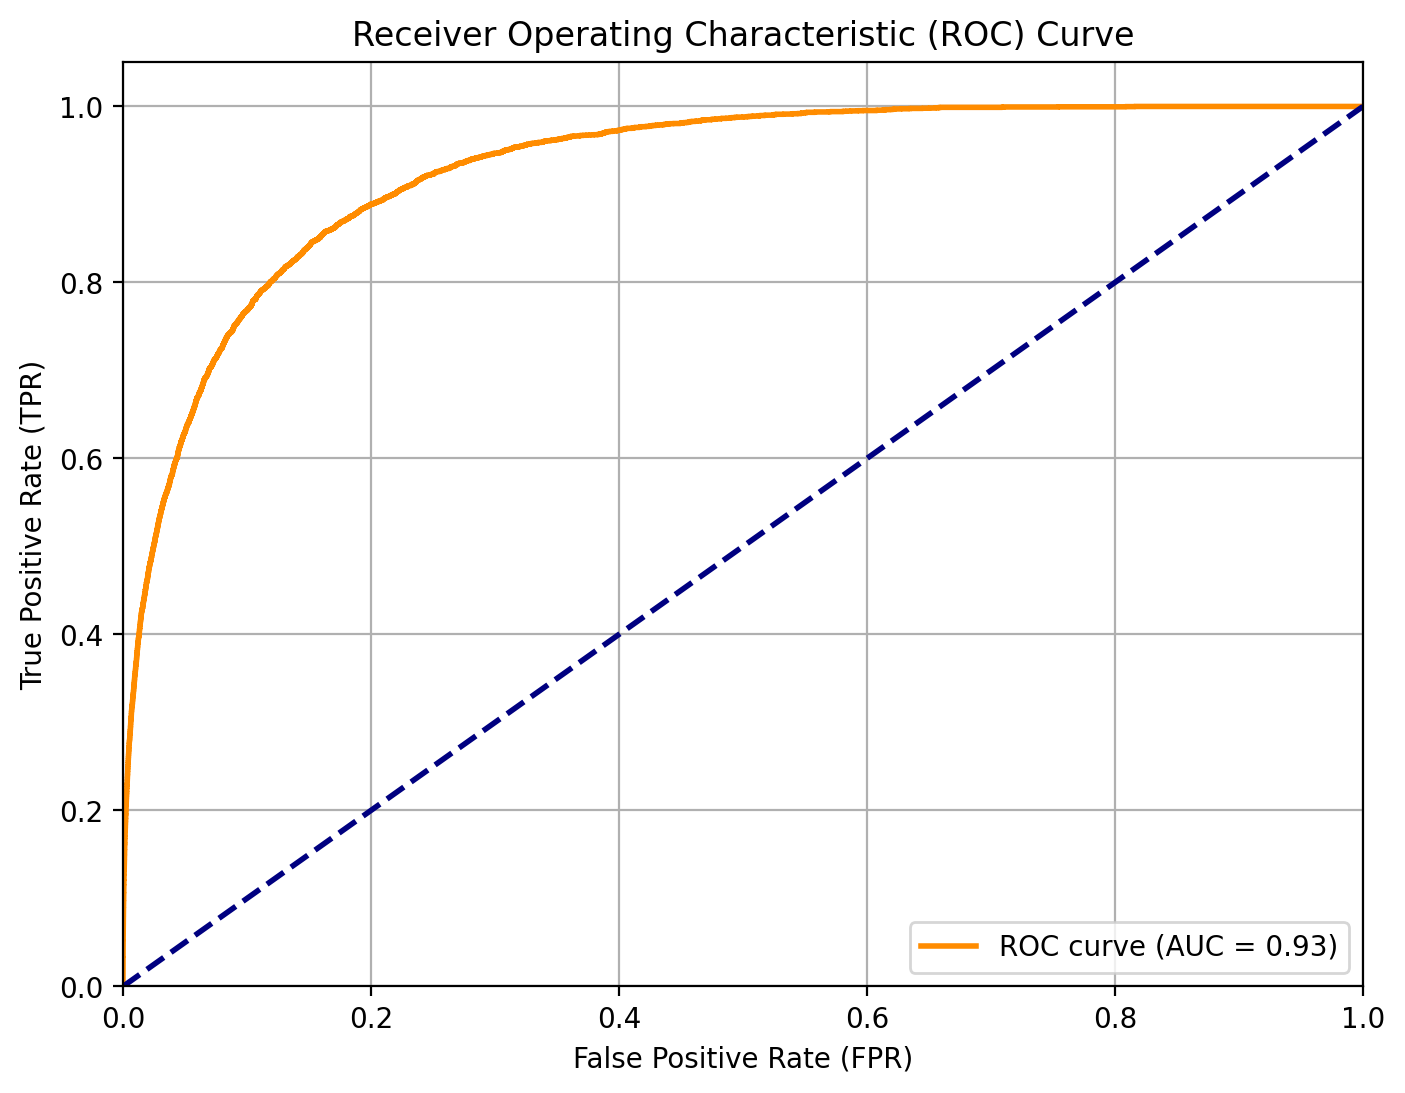

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

print(f"Значение ROC-AUC на тестовой выборке: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [3]:
metrics_df.sort_values('Precision', ascending=False).head(10)

,Threshold,True Positives (TP),False Positives (FP),False Negatives (FN),True Negatives (TN),Recall,Precision,Accuracy,F1-Score,FPR
98,0.99,111.00,237.00,"4,837.00","4,391,689.00",2.24,31.90,99.89,4.19,0.01
97,0.98,391.00,"1,553.00","4,557.00","4,390,373.00",7.90,20.11,99.86,11.35,0.04
96,0.97,643.00,"4,272.00","4,305.00","4,387,654.00",12.99,13.08,99.81,13.04,0.10
95,0.96,899.00,"8,605.00","4,049.00","4,383,321.00",18.17,9.46,99.71,12.44,0.20
94,0.95,"1,130.00","14,497.00","3,818.00","4,377,429.00",22.84,7.23,99.58,10.98,0.33
93,0.94,"1,348.00","21,639.00","3,600.00","4,370,287.00",27.24,5.86,99.43,9.65,0.49
92,0.93,"1,527.00","29,729.00","3,421.00","4,362,197.00",30.86,4.88,99.25,8.44,0.68
91,0.92,"1,684.00","38,735.00","3,264.00","4,353,191.00",34.03,4.17,99.05,7.42,0.88
90,0.91,"1,844.00","48,475.00","3,104.00","4,343,451.00",37.27,3.67,98.83,6.67,1.10
89,0.90,"2,001.00","58,580.00","2,947.00","4,333,346.00",40.44,3.30,98.60,6.11,1.33


In [4]:
metrics_df[(metrics_df['Recall']>50)&(metrics_df['Recall']<70)]

,Threshold,True Positives (TP),False Positives (FP),False Negatives (FN),True Negatives (TN),Recall,Precision,Accuracy,F1-Score,FPR
72,0.73,"3,434.00","297,179.00","1,514.00","4,094,747.00",69.40,1.14,93.21,2.25,6.77
73,0.74,"3,373.00","280,777.00","1,575.00","4,111,149.00",68.17,1.19,93.58,2.33,6.39
74,0.75,"3,316.00","264,737.00","1,632.00","4,127,189.00",67.02,1.24,93.94,2.43,6.03
75,0.76,"3,239.00","248,626.00","1,709.00","4,143,300.00",65.46,1.29,94.31,2.52,5.66
76,0.77,"3,169.00","232,999.00","1,779.00","4,158,927.00",64.05,1.34,94.66,2.63,5.30
77,0.78,"3,111.00","217,785.00","1,837.00","4,174,141.00",62.87,1.41,95.00,2.75,4.96
78,0.79,"3,042.00","202,623.00","1,906.00","4,189,303.00",61.48,1.48,95.35,2.89,4.61
79,0.80,"2,961.00","187,873.00","1,987.00","4,204,053.00",59.84,1.55,95.68,3.02,4.28
80,0.81,"2,876.00","172,990.00","2,072.00","4,218,936.00",58.12,1.64,96.02,3.18,3.94
81,0.82,"2,797.00","158,755.00","2,151.00","4,233,171.00",56.53,1.73,96.34,3.36,3.62


In [18]:
metrics_df.to_csv('metrics_df.csv')

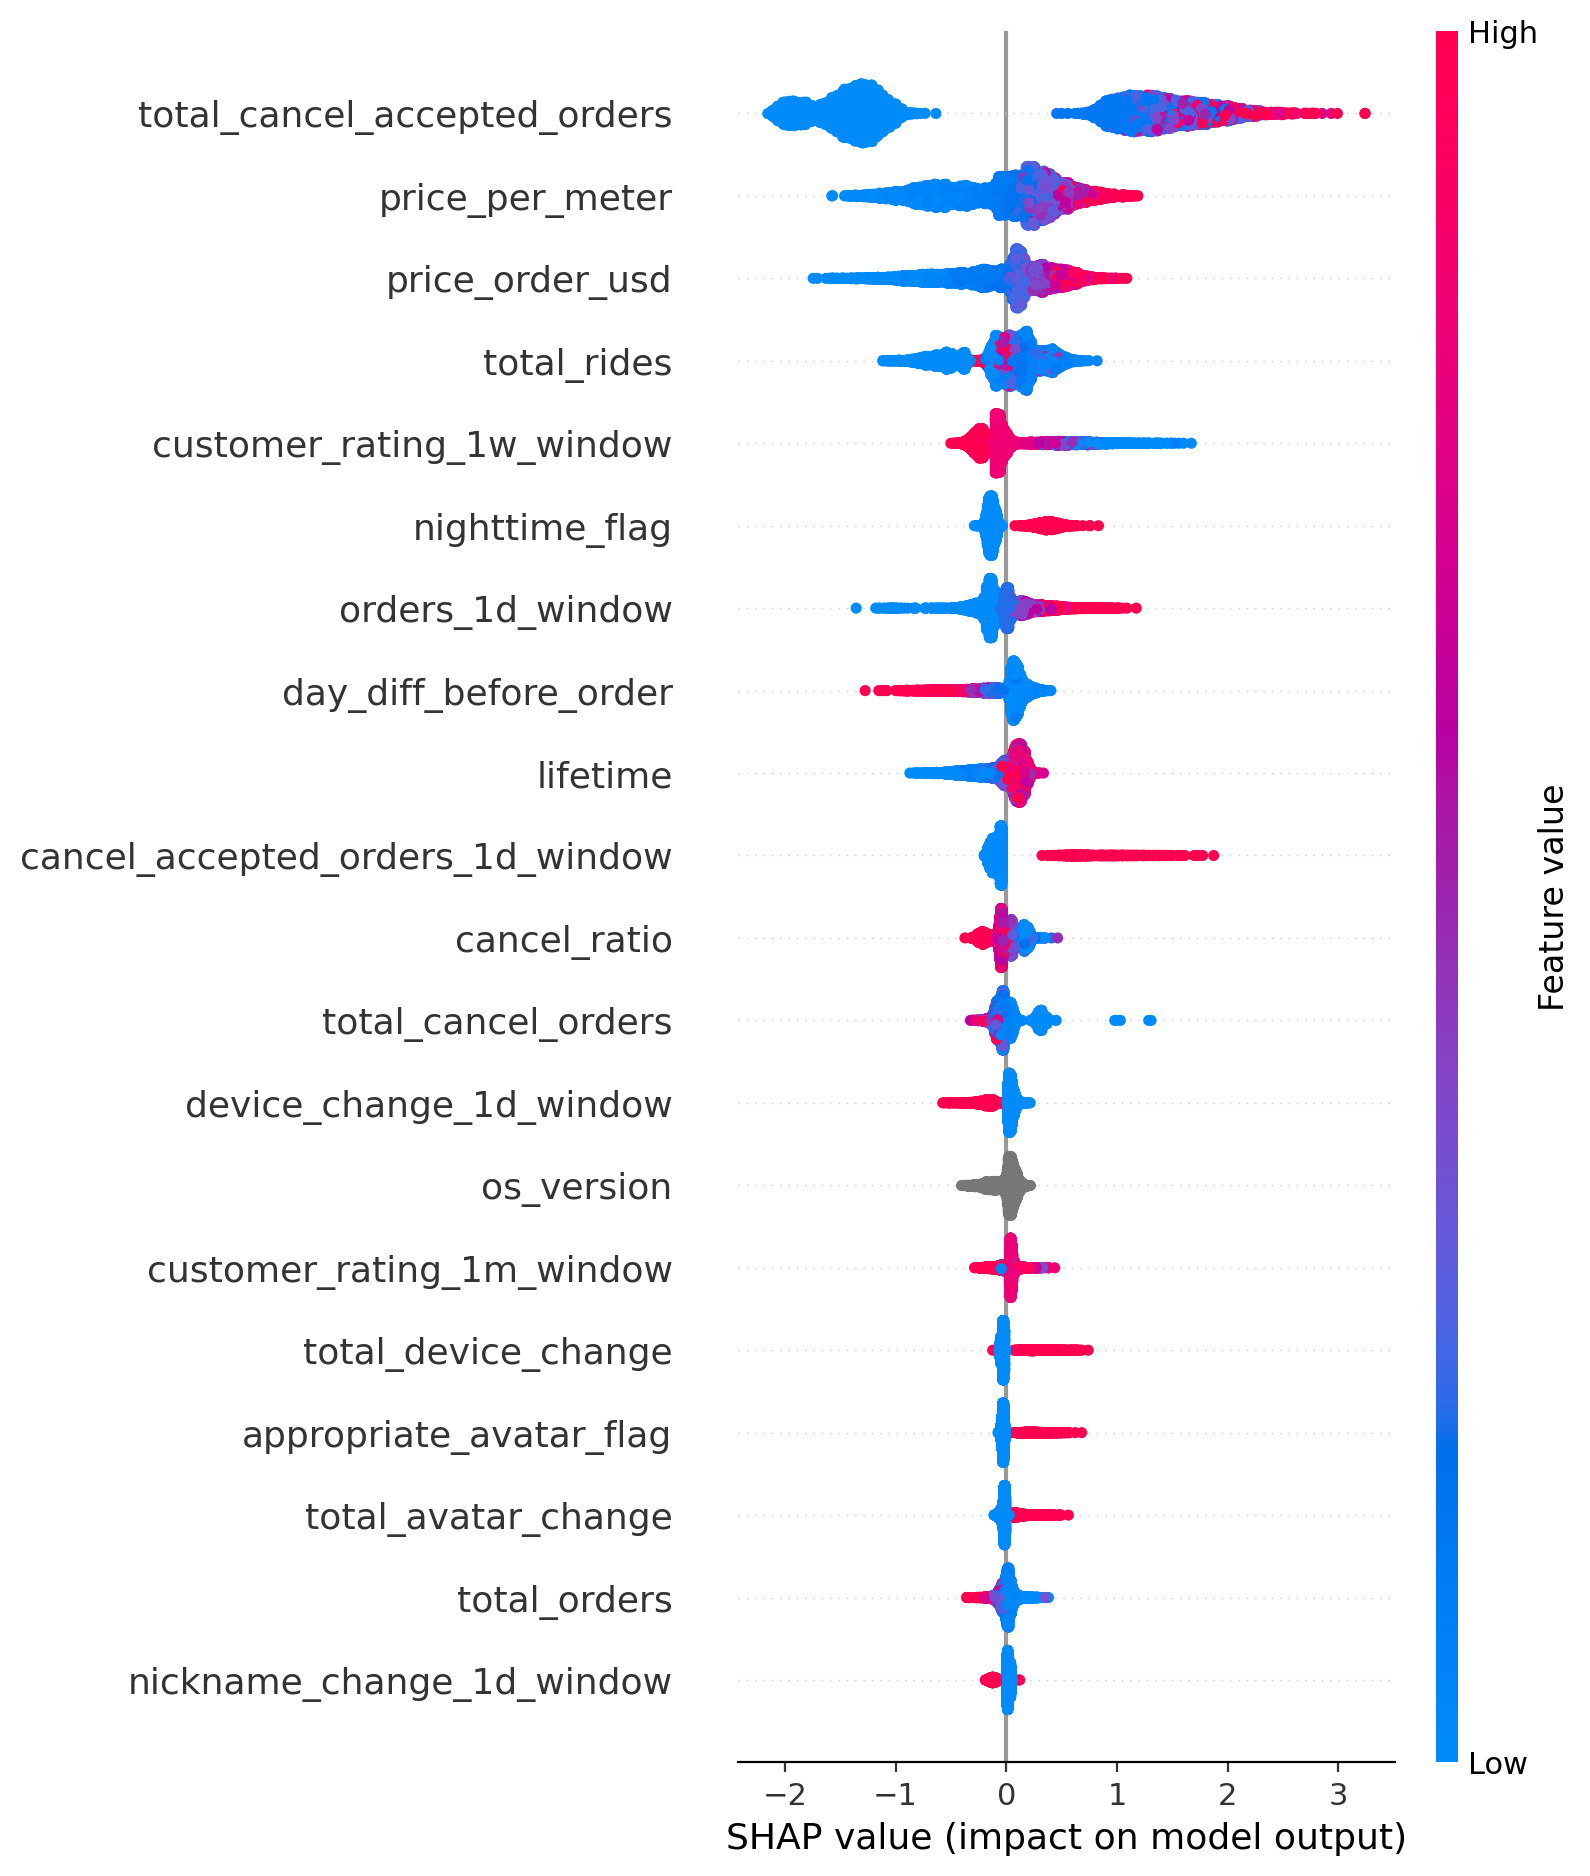

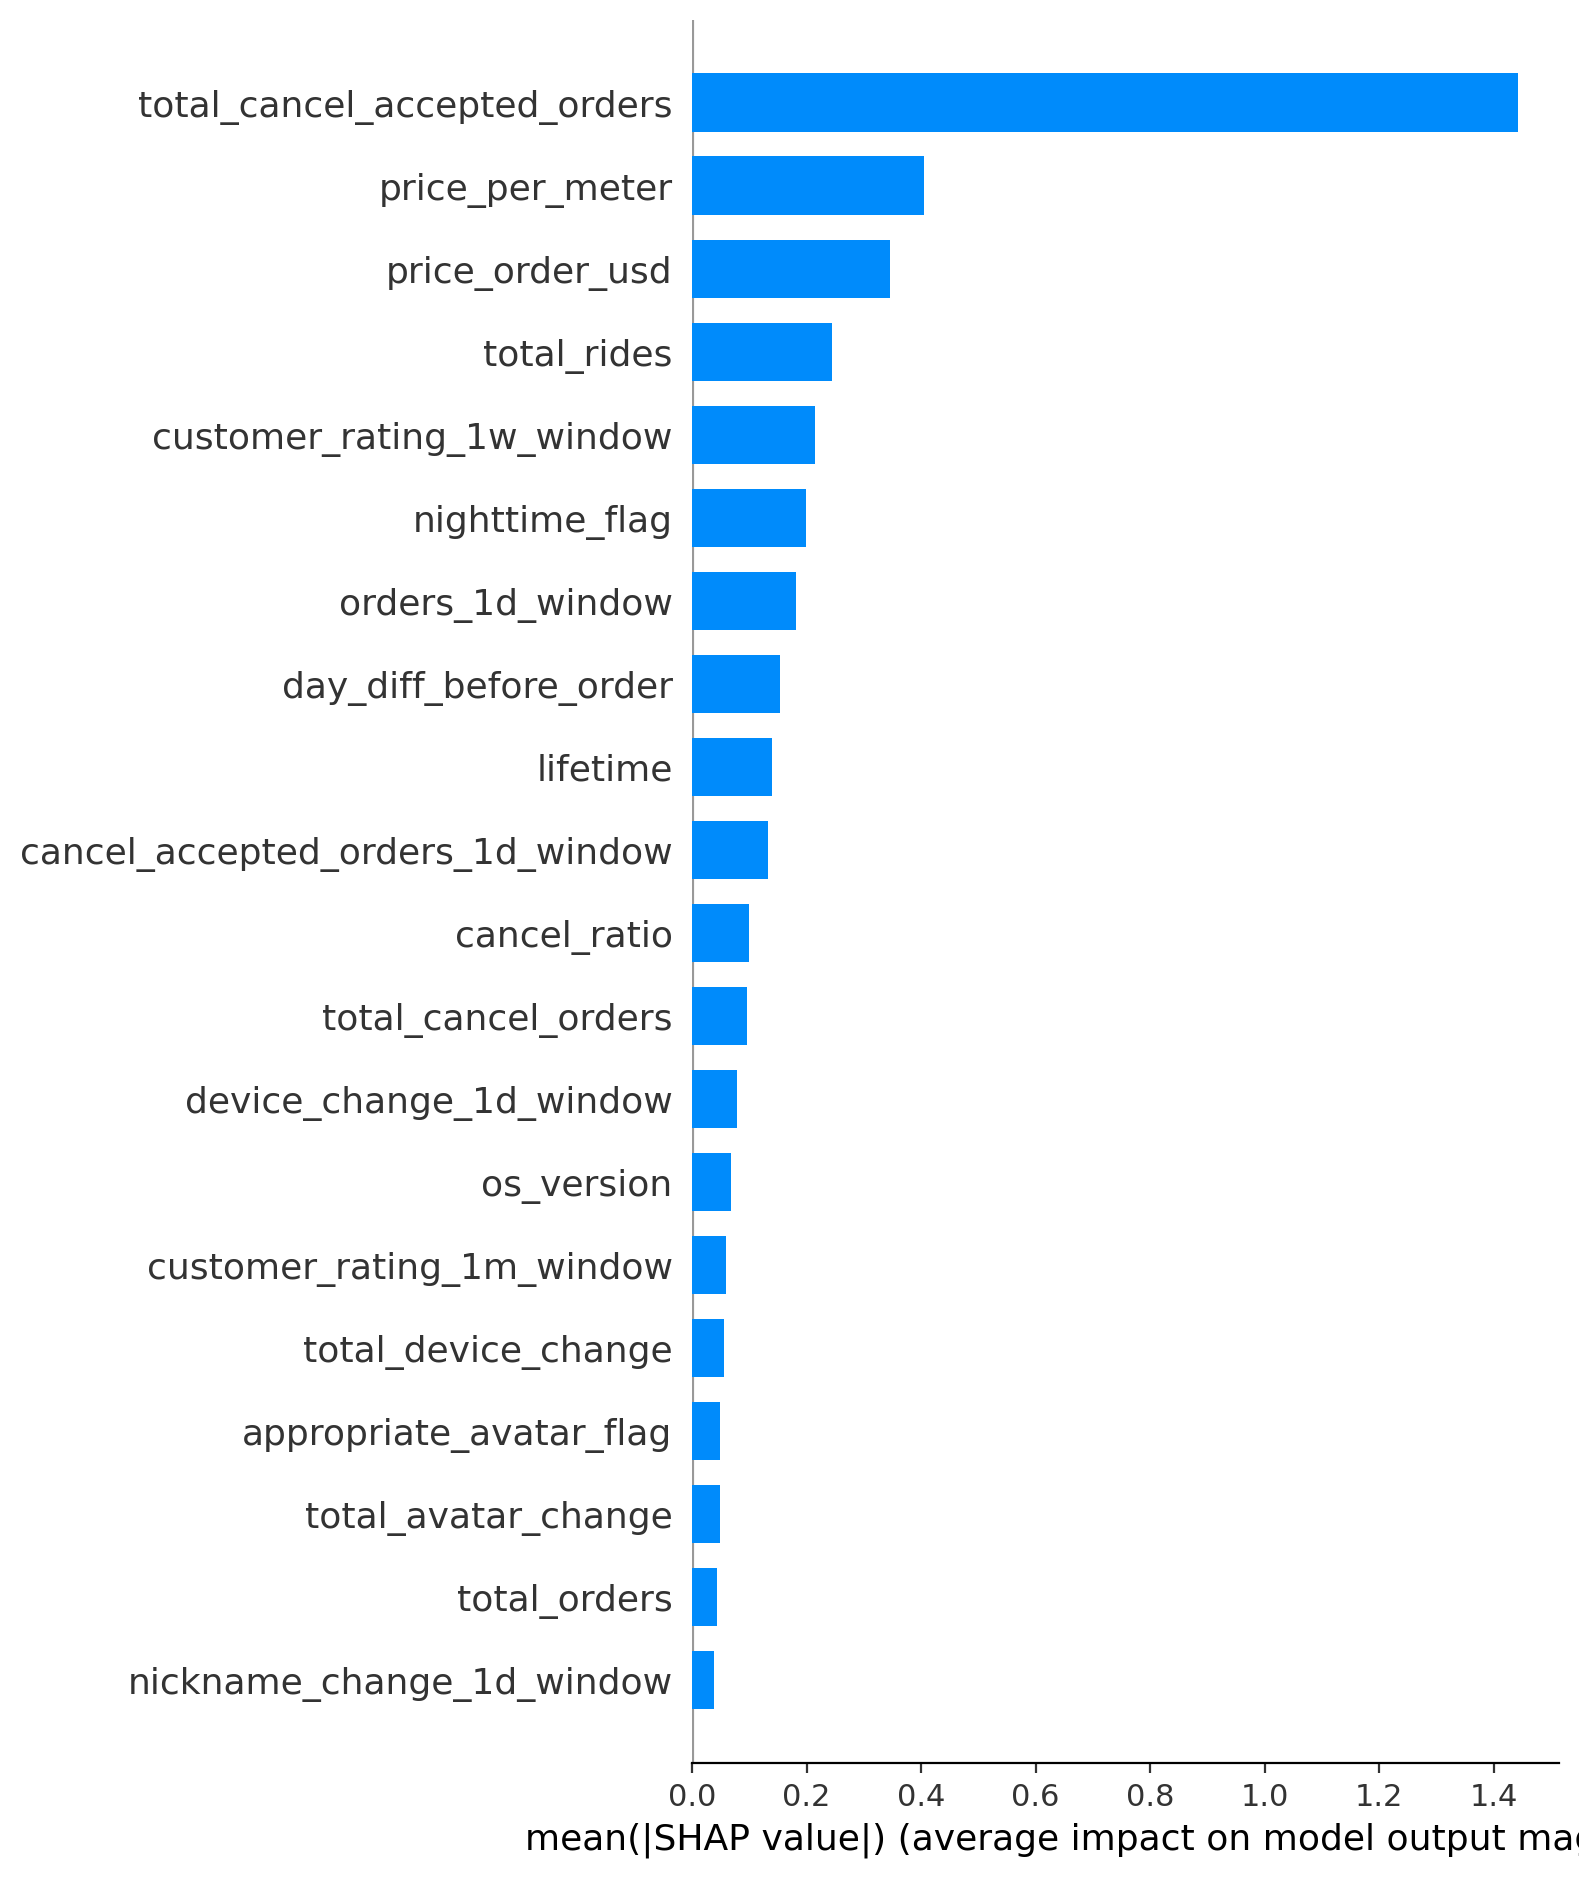

In [5]:
explainer = shap.TreeExplainer(model)
X_sample = X_test.sample(n=10000, random_state=42)
shap_values = explainer.shap_values(X_sample)
if isinstance(shap_values, list):
    if len(shap_values) > 1:
        shap_values_to_plot = shap_values[1]
    else:

        shap_values_to_plot = shap_values[0]
else:
    shap_values_to_plot = shap_values

shap.summary_plot(shap_values_to_plot, X_sample)

shap.summary_plot(shap_values_to_plot, X_sample, plot_type="bar")

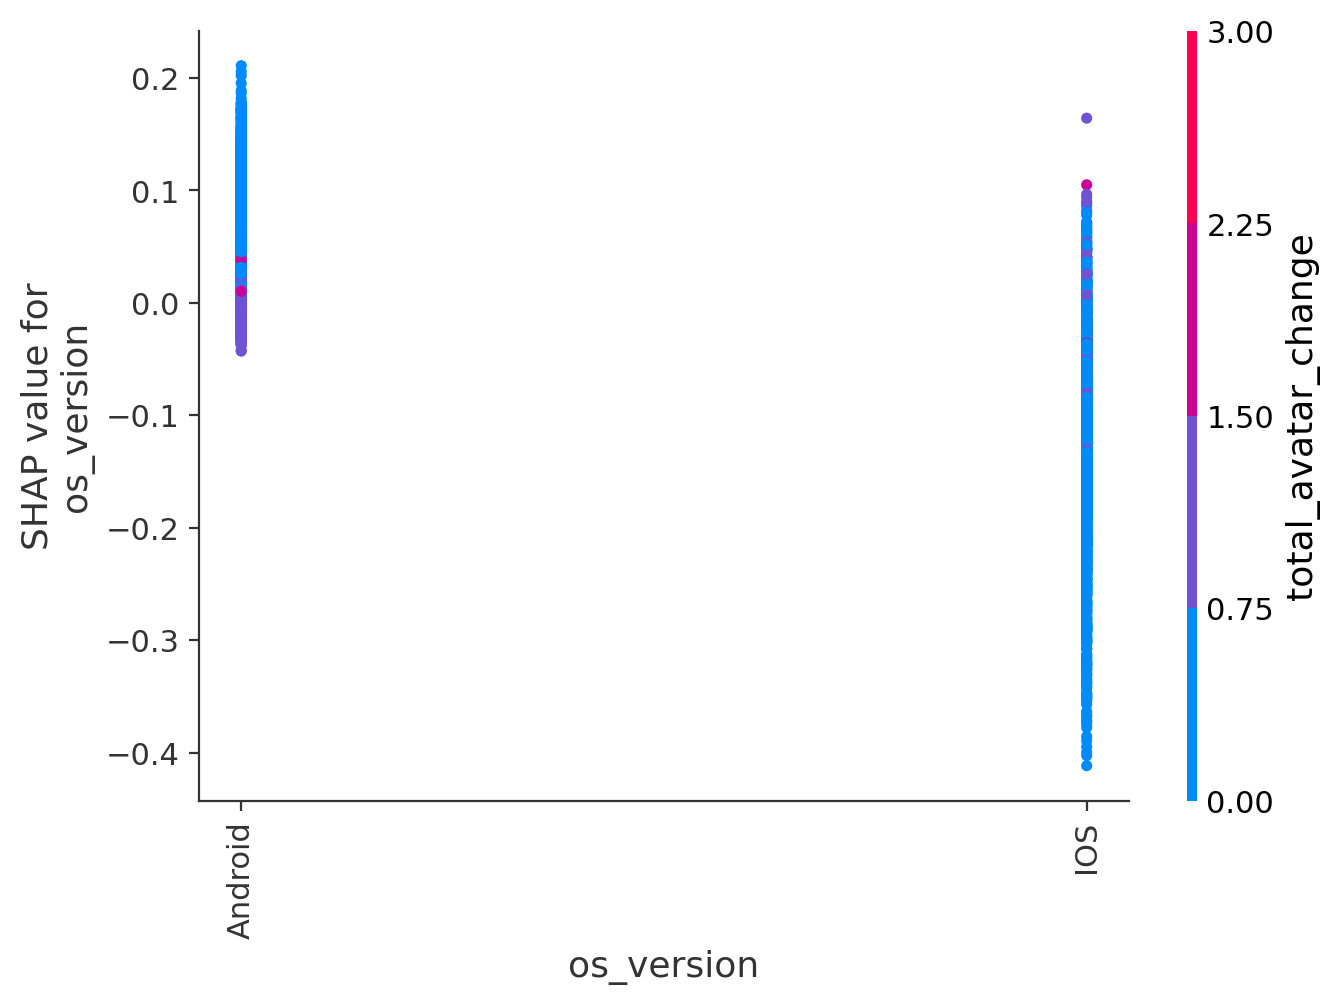

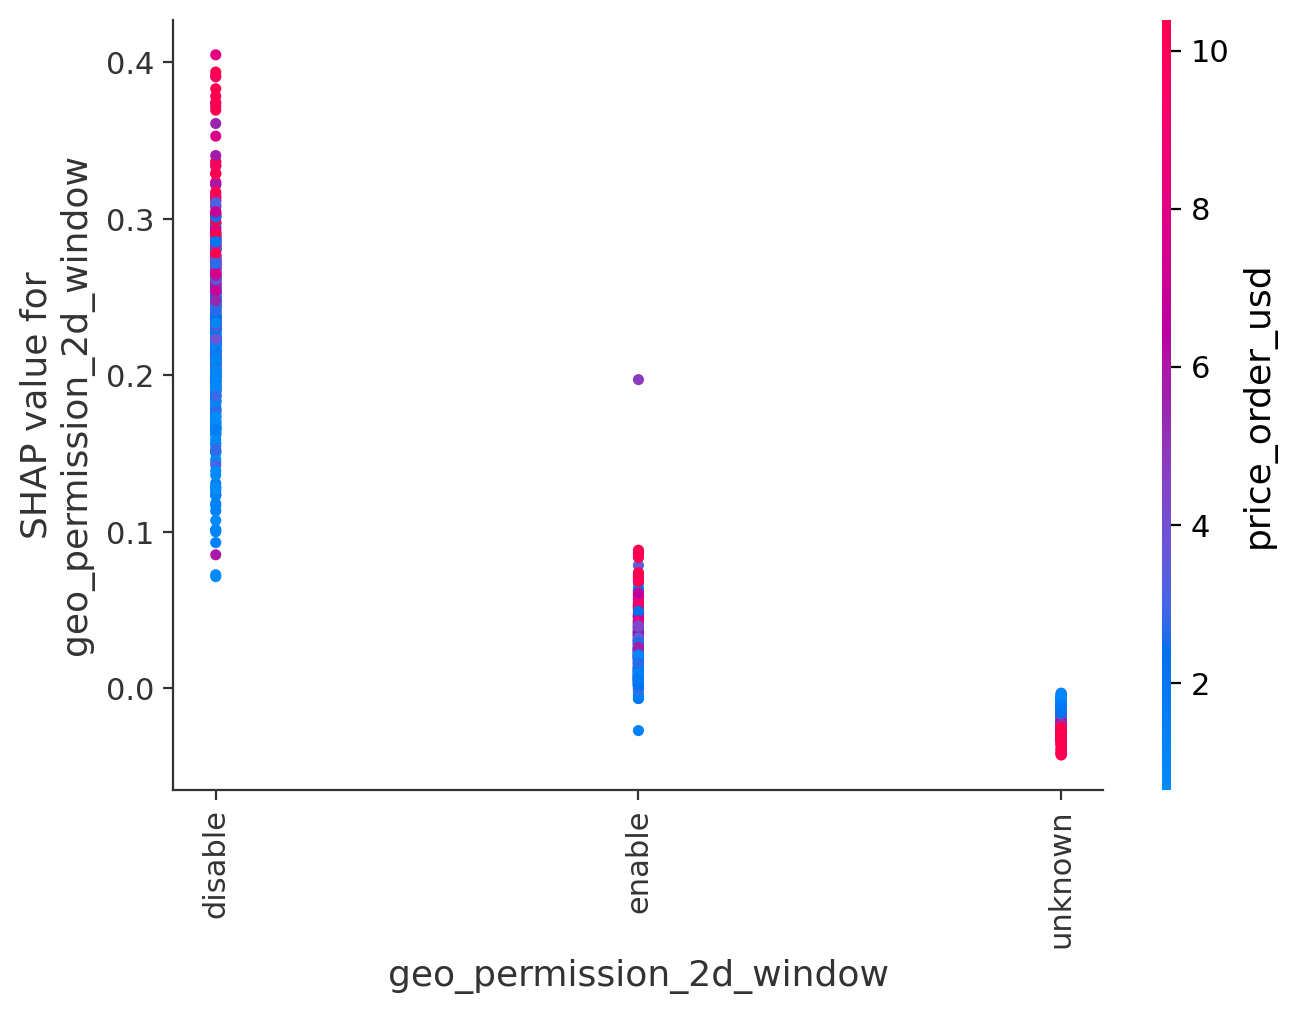

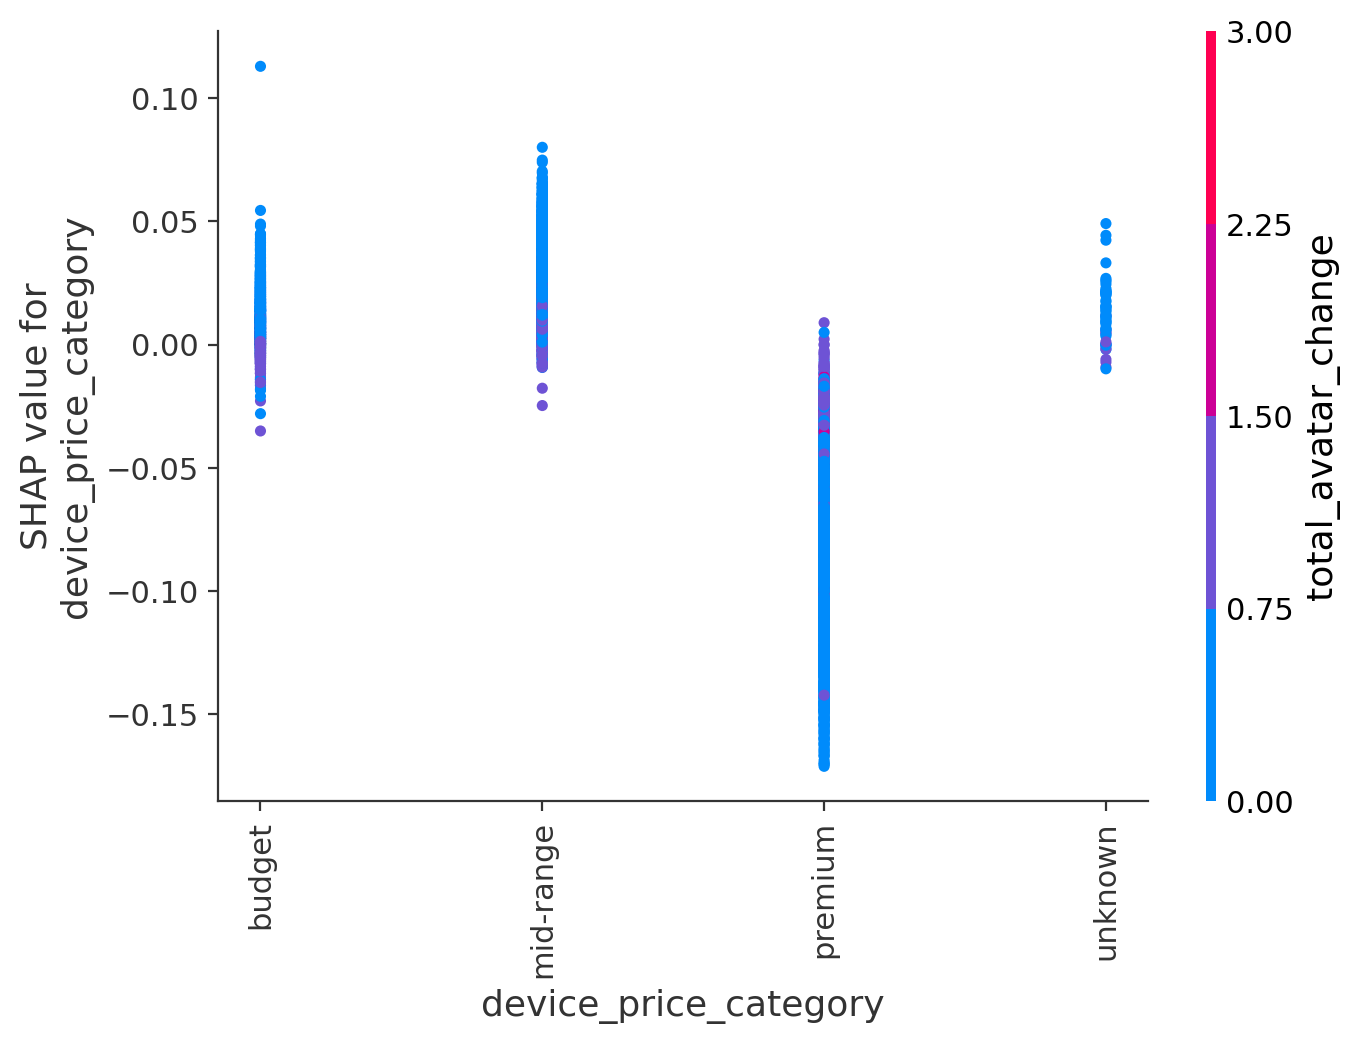

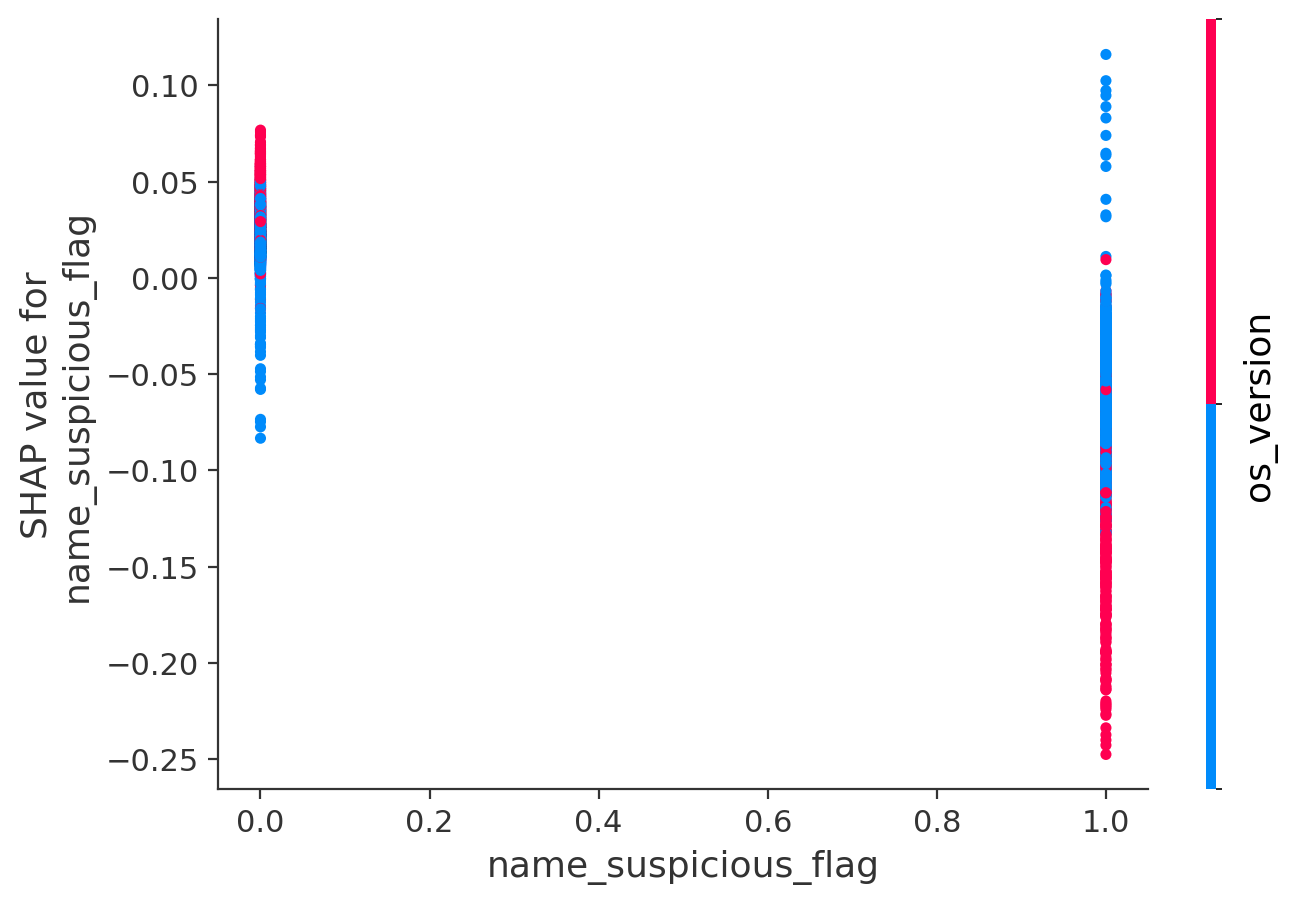

In [6]:

categorical_features = categorical_features + ['name_suspicious_flag']

for value in categorical_features:
    shap.dependence_plot(value, shap_values_to_plot, X_sample)


In [1]:
importance_df

NameError: name 'importance_df' is not defined

##### By Incident level

In [ ]:
model_res = pd.concat([y_test, df_test[['incident_level', 'y_pred_proba', 'city_id']]], axis=1)

levels = ['Red', 'Green', 'Yellow']

df_metric_res = pd.DataFrame()

for level in levels:
    print(f'Region: {level}')

    metrics_df_by_levels = pd.DataFrame(columns=[
        'Threshold',
        'True Positives (TP)', 'False Positives (FP)',
        'False Negatives (FN)', 'True Negatives (TN)',
        'Recall',
        'Precision',
        'Accuracy', 'F1-Score', 'FPR'
    ])


    thresholds = np.arange(0.01, 1.0, 0.01)
    for threshold in thresholds:
        
        y_pred_thresholded = (model_res[(model_res['incident_level'].isna())|(model_res['incident_level']==level)]['y_pred_proba'] >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(model_res[(model_res['incident_level'].isna())|(model_res['incident_level']==level)]['incident_flag'], y_pred_thresholded).ravel()
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        metrics_df_by_levels.loc[len(metrics_df_by_levels)] = [
            threshold, tp, fp, fn, tn,
            recall, precision, accuracy, f1, fpr
        ]
    metrics_df_by_levels['Recall'] = (metrics_df_by_levels['Recall'] * 100).round(3)
    metrics_df_by_levels['Precision'] = (metrics_df_by_levels['Precision'] * 100).round(3)
    metrics_df_by_levels['Accuracy'] = (metrics_df_by_levels['Accuracy'] * 100).round(3)
    metrics_df_by_levels['F1-Score'] = (metrics_df_by_levels['F1-Score'] * 100).round(3)
    metrics_df_by_levels['FPR'] = (metrics_df_by_levels['FPR'] * 100).round(3)
    metrics_df_by_levels['Level'] = level

    df_metric_res = pd.concat([df_metric_res, metrics_df_by_levels])

df_metric_res.head(10)

##### By Incident type

In [15]:
model_res = pd.concat([y_test, df_test[['incident_type', 'y_pred_proba', 'city_id']]], axis=1)

df_metric_res = pd.DataFrame()

for level in tqdm(df_test[~df_test['incident_type'].isna()]['incident_type'].unique()):
    print(f'Region: {level}')

    metrics_df_by_levels = pd.DataFrame(columns=[
        'Threshold',
        'True Positives (TP)', 'False Positives (FP)',
        'False Negatives (FN)', 'True Negatives (TN)',
        'Recall',
        'Precision',
        'Accuracy', 'F1-Score', 'FPR'
    ])


    thresholds = np.arange(0.01, 1.0, 0.01)
    for threshold in thresholds:
        
        y_pred_thresholded = (model_res[(model_res['incident_type'].isna())|(model_res['incident_type']==level)]['y_pred_proba'] >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(model_res[(model_res['incident_type'].isna())|(model_res['incident_type']==level)]['incident_flag'], y_pred_thresholded).ravel()
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        metrics_df_by_levels.loc[len(metrics_df_by_levels)] = [
            threshold, tp, fp, fn, tn,
            recall, precision, accuracy, f1, fpr
        ]
    metrics_df_by_levels['Recall'] = (metrics_df_by_levels['Recall'] * 100).round(3)
    metrics_df_by_levels['Precision'] = (metrics_df_by_levels['Precision'] * 100).round(3)
    metrics_df_by_levels['Accuracy'] = (metrics_df_by_levels['Accuracy'] * 100).round(3)
    metrics_df_by_levels['F1-Score'] = (metrics_df_by_levels['F1-Score'] * 100).round(3)
    metrics_df_by_levels['FPR'] = (metrics_df_by_levels['FPR'] * 100).round(3)
    metrics_df_by_levels['Level'] = level

    df_metric_res = pd.concat([df_metric_res, metrics_df_by_levels])

df_metric_res.head(10)

  0%|          | 0/27 [00:00<?, ?it/s]

Region: Robbery
Region: Threats / insults before/after a trip
Region: Attempted robbery
Region: Damage to someone else's property
Region: Fraud
Region: Bothering before/after a trip for the purpose of dating SMS, call, messengers
Region: Car theft
Region: Theft
Region: Buying/transportation of drugs
Region: Physical impact
Region: Bothering before/after a trip SMS, call, messengers
Region: Threat with weapons
Region: Bad attitude
Region: Proposal of an intimate nature
Region: Acquaintance
Region: The passenger did not pay for the trip
Region: Fight/bodily harm
Region: Intimate actions
Region: Discrimination
Region: Fake purchases, raids
Region: Fine for illegal transport
Region: Kidnapping
Region: Financial dispute
Region: Violation of data privacy
Region: The driver overestimated the price of the trip
Region: Rape
Region: Murder


,Threshold,True Positives (TP),False Positives (FP),False Negatives (FN),True Negatives (TN),Recall,Precision,Accuracy,F1-Score,FPR,Level
0,0.01,499.00,"3,747,769.00",0.00,"644,157.00",100.00,0.01,14.68,0.03,85.33,Robbery
1,0.02,499.00,"3,335,990.00",0.00,"1,055,936.00",100.00,0.01,24.05,0.03,75.96,Robbery
2,0.03,498.00,"3,084,689.00",1.00,"1,307,237.00",99.80,0.02,29.77,0.03,70.23,Robbery
3,0.04,498.00,"2,871,278.00",1.00,"1,520,648.00",99.80,0.02,34.63,0.04,65.38,Robbery
4,0.05,498.00,"2,687,149.00",1.00,"1,704,777.00",99.80,0.02,38.82,0.04,61.18,Robbery
5,0.06,498.00,"2,533,351.00",1.00,"1,858,575.00",99.80,0.02,42.33,0.04,57.68,Robbery
6,0.07,496.00,"2,403,122.00",3.00,"1,988,804.00",99.40,0.02,45.29,0.04,54.72,Robbery
7,0.08,496.00,"2,290,485.00",3.00,"2,101,441.00",99.40,0.02,47.85,0.04,52.15,Robbery
8,0.09,494.00,"2,193,151.00",5.00,"2,198,775.00",99.00,0.02,50.07,0.04,49.94,Robbery
9,0.10,491.00,"2,107,909.00",8.00,"2,284,017.00",98.40,0.02,52.01,0.05,47.99,Robbery


In [16]:
df_metric_res.to_csv('df_metric_res.csv', index=True)
model_res.to_csv('model_res.csv', index=True)


#### By cities

In [ ]:
df_test = pd.read_csv('df_test.csv')

df_test.head()

In [ ]:
df_cities = read_bq("""
SELECT city_id, country_id, country_name, macroregion_name
FROM indriver-e6e40.heap.vw_macroregion_mapping
""")

df_cities.head()

In [ ]:
df_test = df_test.merge(df_cities, left_on='city_id', right_on='city_id', how='inner')

df_test_by_region = df_test.rename(columns={'Unnamed: 0':'index'}).set_index('index')

df_test.shape

In [ ]:
model_res = pd.merge(y_test, df_test_by_region[['incident_level', 'y_pred_proba', 'country_name', 'macroregion_name']], left_index=True, right_index=True)


df_metric_res = pd.DataFrame()

for country in tqdm(model_res['macroregion_name'].unique()):
    print(f'Region: {country}')

    metrics_df_by_region = pd.DataFrame(columns=[
        'Threshold',
        'True Positives (TP)', 'False Positives (FP)',
        'False Negatives (FN)', 'True Negatives (TN)',
        'Recall',
        'Precision',
        'Accuracy', 'F1-Score', 'FPR'
    ])


    thresholds = np.arange(0.01, 1.0, 0.01)
    for threshold in thresholds:
        
        y_pred_thresholded = (model_res[(model_res['macroregion_name']==country)]['y_pred_proba'] >= threshold).astype(int)

        try:
            tn, fp, fn, tp = confusion_matrix(model_res[(model_res['macroregion_name']==country)]['incident_flag'], y_pred_thresholded).ravel()
        except ValueError:
            continue
        
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        metrics_df_by_region.loc[len(metrics_df_by_region)] = [
            threshold, tp, fp, fn, tn,
            recall, precision, accuracy, f1, fpr
        ]
    metrics_df_by_region['Recall'] = (metrics_df_by_region['Recall'] * 100).round(3)
    metrics_df_by_region['Precision'] = (metrics_df_by_region['Precision'] * 100).round(3)
    metrics_df_by_region['Accuracy'] = (metrics_df_by_region['Accuracy'] * 100).round(3)
    metrics_df_by_region['F1-Score'] = (metrics_df_by_region['F1-Score'] * 100).round(3)
    metrics_df_by_region['FPR'] = (metrics_df_by_region['FPR'] * 100).round(3)
    metrics_df_by_region['Level'] = country

    df_metric_res_reg = pd.concat([df_metric_res, metrics_df_by_region])

df_metric_res_reg.head(10)

In [ ]:
df_metric_res_reg.to_csv('df_metric_res_reg.csv', index=True)


In [ ]:
df_metric_res.sort_values('F1-Score', ascending=False).head(15)

### Log regression

In [3]:
df_sample_for_ml[[
    'price_per_meter', 'price_order_usd', 'total_cancel_accepted_orders', 'customer_rating_1w_window', 'day_diff_before_order', 'lifetime',
    'total_rides', 'orders_1d_window', 'customer_rating_1m_window', 'bans_before_order', 'total_cancel_orders', 'total_orders', 'nighttime_flag', 'cancel_accepted_orders_1d_window'
    ] + ['user_id', 'incident_level', 'incident_type', 'city_id', 'complaints_in_feed', 'appeals_feed_1m', 'appeals_feed_7w', 'incident_flag']].head()


,price_per_meter,price_order_usd,total_cancel_accepted_orders,customer_rating_1w_window,day_diff_before_order,lifetime,total_rides,orders_1d_window,customer_rating_1m_window,bans_before_order,total_cancel_orders,total_orders,nighttime_flag,cancel_accepted_orders_1d_window,user_id,incident_level,incident_type,city_id,complaints_in_feed,appeals_feed_1m,appeals_feed_7w,incident_flag
0,0.85,0.85,6.00,5.00,27,139,7.00,3,5.00,0,6.00,14.00,0,1,289646646,NaN,NaN,5640,0,0,0,0
1,0.92,2.88,1.00,3.81,1,136,9.00,1,3.81,0,12.00,22.00,1,0,290241495,NaN,NaN,4532,0,0,0,0
2,1.75,2.60,0.00,4.77,13,101,6.00,1,4.73,0,1.00,7.00,1,0,295896279,NaN,NaN,6079,0,0,0,0
3,0.35,1.96,4.00,1.00,3,230,4.00,2,1.00,1,11.00,17.00,1,0,275248105,NaN,NaN,10155,0,0,0,0
4,0.50,26.89,0.00,4.80,0,119,0.00,1,4.80,0,2.00,2.00,1,0,292936861,NaN,NaN,840,0,0,0,0


In [ ]:

df_sample_for_ml = pd.read_csv("/Users/renatyunison/Desktop/VSC scripts/Working/df_sample_for_ml.csv")

user_ids = df_sample_for_ml['user_id']
incident_level = df_sample_for_ml['incident_level']
incident_type = df_sample_for_ml['incident_type']
city_id = df_sample_for_ml['city_id']

df_full = df_sample_for_ml.copy()


sample_size_frac = 0.5


_, df_sampled = train_test_split(df_full, test_size=sample_size_frac, random_state=42, stratify=df_full['incident_flag'])

df = df_sampled.copy()


TARGET = 'incident_flag'

X = df[[
    'price_per_meter', 'price_order_usd', 'total_cancel_accepted_orders', 'customer_rating_1w_window', 'day_diff_before_order', 'lifetime',
    'total_rides', 'orders_1d_window', 'customer_rating_1m_window', 'bans_before_order', 'total_cancel_orders', 'total_orders', 'nighttime_flag', 'cancel_accepted_orders_1d_window'
    ] + ['user_id', 'incident_level', 'incident_type', 'city_id', 'complaints_in_feed', 'appeals_feed_1m', 'appeals_feed_7w', 'incident_flag']].drop(columns=[TARGET, 'user_id', 'incident_level', 'incident_type', 'city_id'])
y = df[TARGET]

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
for col in numerical_features:
    if X[col].isnull().any():
        X[col] = X[col].fillna(0)

object_cols = X.select_dtypes(include='object').columns.tolist()
for col in object_cols:
    X[col] = X[col].astype('category')

print("Предобработка данных для логистической регрессии...")

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='category').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'

print("Разделение данных и обучение модели...")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42))
])

logreg_pipeline.fit(X_train, y_train)

print("Обучение модели завершено.")

y_pred_proba = logreg_pipeline.predict_proba(X_test)[:, 1]

print("Расчет метрик для разных порогов...")
metrics_df = pd.DataFrame(columns=[
    'Threshold',
    'True Positives (TP)', 'False Positives (FP)',
    'False Negatives (FN)', 'True Negatives (TN)',
    'Recall',
    'Precision',
    'Accuracy', 'F1-Score', 'FPR'
])

thresholds = np.arange(0.01, 1.0, 0.01)
for threshold in thresholds:
    y_pred_thresholded = (y_pred_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresholded).ravel()
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    metrics_df.loc[len(metrics_df)] = [
        threshold, tp, fp, fn, tn,
        recall, precision, accuracy, f1, fpr
    ]

metrics_df['Recall'] = (metrics_df['Recall'] * 100).round(3)
metrics_df['Precision'] = (metrics_df['Precision'] * 100).round(3)
metrics_df['Accuracy'] = (metrics_df['Accuracy'] * 100).round(3)
metrics_df['F1-Score'] = (metrics_df['F1-Score'] * 100).round(3)
metrics_df['FPR'] = (metrics_df['FPR'] * 100).round(3)
    
print("Расчет метрик завершен.")
print(metrics_df)

print("\n" + "="*50)
print("Анализ важности признаков (коэффициенты)")
print("="*50)

coefficients = logreg_pipeline.named_steps['classifier'].coef_[0]

all_feature_names = numerical_features + ohe_feature_names.tolist()

importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})

importance_df['Absolute_Coefficient'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='Absolute_Coefficient', ascending=False)
print(importance_df.head(15))

Выгружаю данные..
Данные загружены. Исходный размер: (21984369, 68)
Создание стратифицированной выборки размером 50.0%...
Размер уменьшенной выборки: (10992185, 68)
-----------------------------------------------------------------------------
Предобработка данных...
Предобработка данных для логистической регрессии...
Разделение данных и обучение модели...
Обучение модели завершено.
Расчет метрик для разных порогов...
Расчет метрик завершен.
    Threshold  True Positives (TP)  False Positives (FP)  False Negatives (FN)  True Negatives (TN)  Recall  Precision  Accuracy  F1-Score   FPR
0        0.01             2,473.00          2,195,523.00                  1.00               440.00   99.96       0.11      0.13      0.23 99.98
1        0.02             2,473.00          2,195,257.00                  1.00               706.00   99.96       0.11      0.14      0.23 99.97
2        0.03             2,472.00          2,194,889.00                  2.00             1,074.00   99.92       0.11  

NotFittedError: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

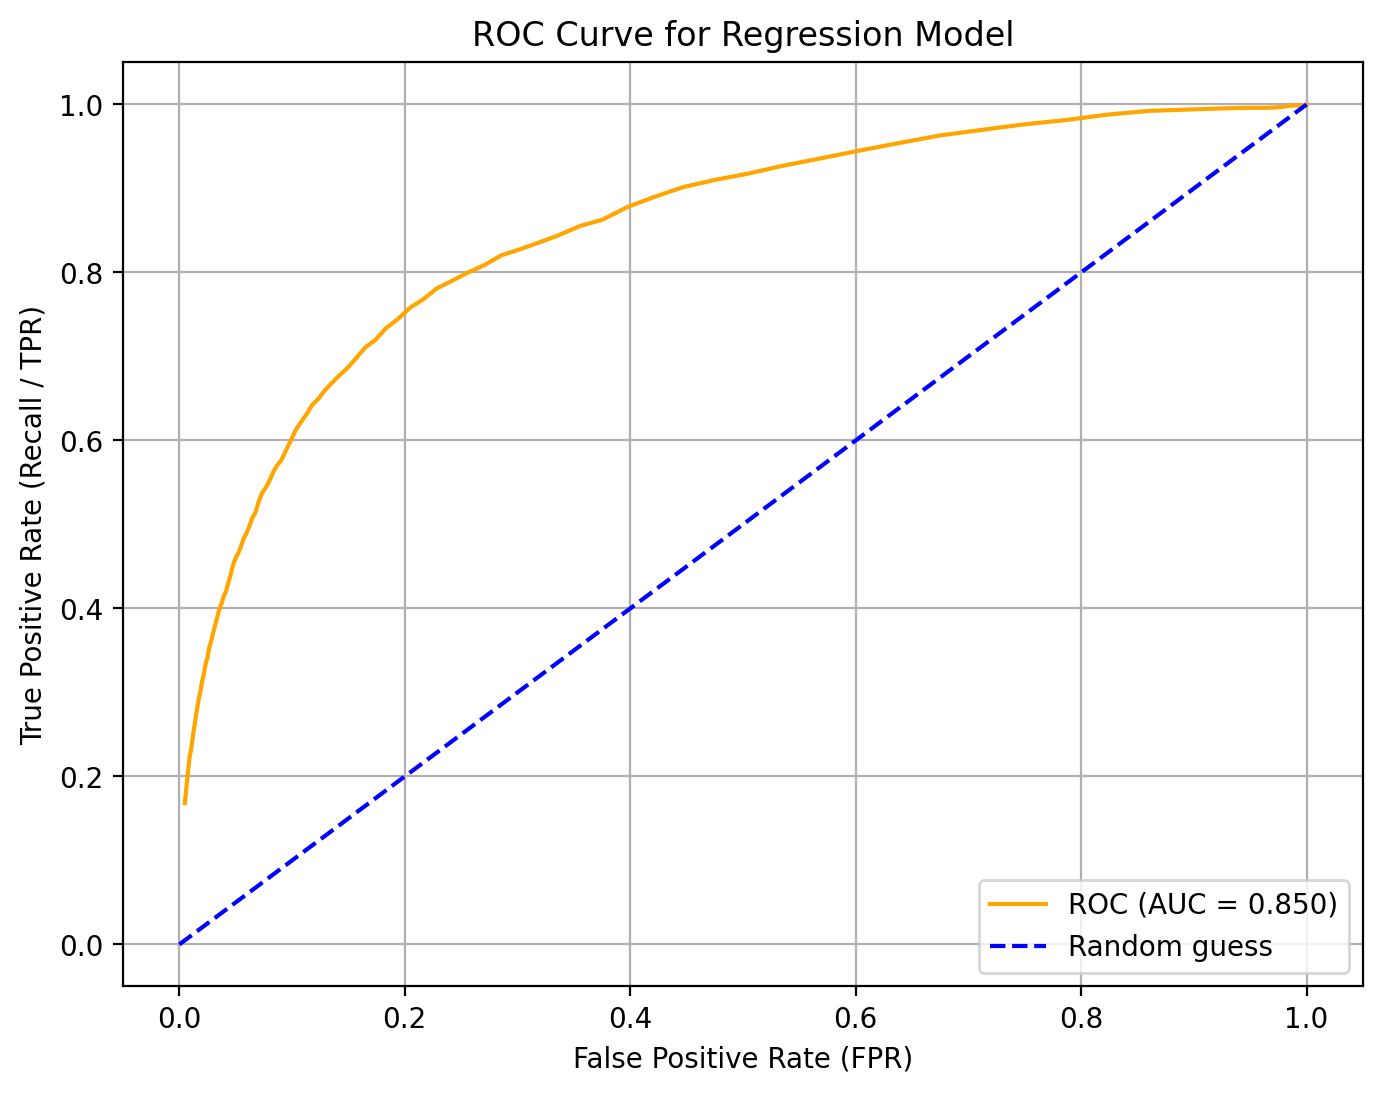

In [ ]:

df = pd.read_csv('Safety Scoring ML - Error matrix Log regression.csv')

df["TPR"] = df["Recall"] / 100
df["FPR"] = df["FPR"] / 100

df = df.sort_values("FPR")
roc_auc = auc(df["FPR"], df["TPR"])

plt.figure(figsize=(8,6))
plt.plot(df["FPR"], df["TPR"], marker='', label=f"ROC (AUC = {roc_auc:.3f})", color='orange')
plt.plot([0,1], [0,1], 'k--', label="Random guess", color='blue')

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (Recall / TPR)")
plt.title("ROC Curve for Regression Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
all_feature_names = numerical_features

importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})

importance_df['Absolute_Coefficient'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='Absolute_Coefficient', ascending=False)
importance_df.head(15)

,Feature,Coefficient,Absolute_Coefficient
6,total_rides,-1.01,1.01
11,total_orders,0.80,0.80
2,total_cancel_accepted_orders,0.70,0.70
13,cancel_accepted_orders_1d_window,0.45,0.45
10,total_cancel_orders,-0.44,0.44
7,orders_1d_window,0.44,0.44
3,customer_rating_1w_window,-0.36,0.36
1,price_order_usd,0.33,0.33
12,nighttime_flag,0.32,0.32
4,day_diff_before_order,-0.28,0.28


In [8]:
metrics_df.to_csv('log_regression.csv')

### Feature importance

In [ ]:
import pandas as pd
import numpy as np
from typing import List, Union

def calculate_feature_importance_share(
    importance_scores: Union[np.ndarray, List[float]], 
    feature_names: List[str]
) -> pd.DataFrame:
    """
    Рассчитывает относительный и кумулятивный процент важности признаков.

    Args:
        importance_scores: Массив или список с оценками важности признаков.
        feature_names: Список названий признаков.

    Returns:
        DataFrame с отсортированными признаками и их долей важности.
    """
    if len(importance_scores) != len(feature_names):
        raise ValueError("Размеры массивов 'importance_scores' и 'feature_names' должны совпадать.")
        
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance_Score': np.abs(importance_scores) # Используем абсолютное значение для коэффициентов
    })
    
    # Сортируем по убыванию
    importance_df = importance_df.sort_values(by='Importance_Score', ascending=False)
    
    # Рассчитываем общую сумму важности
    total_importance = importance_df['Importance_Score'].sum()
    
    # Рассчитываем относительный процент
    importance_df['Relative_Share (%)'] = (importance_df['Importance_Score'] / total_importance) * 100
    
    # Рассчитываем кумулятивный процент
    importance_df['Cumulative_Share (%)'] = importance_df['Relative_Share (%)'].cumsum()
    
    return importance_df.reset_index(drop=True)

lgbm_importance = model.feature_importances_
lgbm_feature_names = X_train.columns.tolist()

lgbm_importance_df = calculate_feature_importance_share(lgbm_importance, lgbm_feature_names)

lgbm_importance_df.head(10)




logreg_coeffs = logreg_pipeline.named_steps['classifier'].coef_[0]

all_feature_names = numerical_features

logreg_importance_df = calculate_feature_importance_share(logreg_coeffs, all_feature_names)

print("\n--- Важность признаков для логистической регрессии (доля) ---")
print(logreg_importance_df.head(10))

top_80_percent_features = logreg_importance_df[logreg_importance_df['Cumulative_Share (%)'] <= 80]
print("\n--- 80% самых важных признаков в логистической регрессии ---")
print(top_80_percent_features)

,Feature,Importance_Score,Relative_Share (%),Cumulative_Share (%)
0,price_per_meter,509,9.98,9.98
1,price_order_usd,460,9.02,19.00
2,total_cancel_accepted_orders,411,8.06,27.06
3,customer_rating_1w_window,409,8.02,35.08
4,day_diff_before_order,337,6.61,41.69
5,lifetime,327,6.41,48.10
6,total_rides,297,5.82,53.92
7,orders_1d_window,275,5.39,59.31
8,customer_rating_1m_window,198,3.88,63.20
9,bans_before_order,141,2.76,65.96


In [11]:
logreg_importance_df

,Feature,Importance_Score,Relative_Share (%),Cumulative_Share (%)
0,total_rides,1.01,17.30,17.30
1,total_orders,0.80,13.60,30.89
2,total_cancel_accepted_orders,0.70,11.91,42.80
3,cancel_accepted_orders_1d_window,0.45,7.68,50.47
4,total_cancel_orders,0.44,7.57,58.04
5,orders_1d_window,0.44,7.46,65.50
6,customer_rating_1w_window,0.36,6.13,71.63
7,price_order_usd,0.33,5.67,77.30
8,nighttime_flag,0.32,5.44,82.74
9,day_diff_before_order,0.28,4.82,87.55


In [29]:
lgbm_importance_df[lgbm_importance_df['Cumulative_Share (%)']>80]

,Feature,Importance_Score,Relative_Share (%),Cumulative_Share (%)
16,distance_meters,94,1.84,81.49
17,os_version,90,1.76,83.25
18,total_avatar_change,84,1.65,84.90
19,appropriate_avatar_flag,74,1.45,86.35
20,device_change_1d_window,70,1.37,87.73
21,total_device_change,64,1.25,88.98
22,nickname_change_7d_window,61,1.20,90.18
23,name_suspicious_flag,50,0.98,91.16
24,device_price_category,50,0.98,92.14
25,geo_permission_2d_window,49,0.96,93.10
